In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

# initialize output
wing_characters = dict()
wing_characters_stats = dict()

In [2]:
orig_img_dir = './real_samples/nearest1000/orig'
d40_img_dir = './real_samples/nearest1000/d40'
d512_img_dir = './real_samples/nearest1000/d512'

orig_img_files = [f'./{orig_img_dir}/{f}' for f in os.listdir(f'{orig_img_dir}') if f.endswith('.jpg')]
d40_img_files = [f'./{d40_img_dir}/{f}' for f in os.listdir(f'{d40_img_dir}') if f.endswith('.png')]
d512_img_files = [f'./{d512_img_dir}/{f}' for f in os.listdir(f'{d512_img_dir}') if f.endswith('.png')]
orig_img_files.sort()
d40_img_files.sort()
d512_img_files.sort()
len(orig_img_files), len(d40_img_files), len(d512_img_files)

(1071, 1071, 1071)

In [3]:
# 取出亮度值的指定百分位數
def hsv_vp(per, hsvs):
    return np.quantile(np.concatenate(hsvs)[:,2], per/100)

def minMaxScaler(v):
    return (v - v.min()) / (v.max() - v.min())

def leftSideSample(img):
    return img[78:178, :100, :]

In [21]:
# target = 'orig'
# target = 'd40'
target = 'd512'

if target == 'orig':
    target_img_files = orig_img_files
elif target == 'd40':
    target_img_files = d40_img_files
elif target == 'd512':
    target_img_files = d512_img_files
else:
    target_img_files = orig_img_files + d512_img_files

# 前景的 RGB 值
rgbs = []
# 前景的 HSV 值
hsvs = []

grays = []

# 前景所在的 y, x 坐標值
img_fg_idxs = []

bboxes = []
w_binarys = []

for idx_, w_ in enumerate(target_img_files):
    w_img = cv2.imread(f'{w_}', cv2.IMREAD_UNCHANGED)[:,:,:3]
    if target == 'orig':
        w_img = cv2.blur(w_img, (7, 7))
    w_img = leftSideSample(w_img)
    w_img = cv2.cvtColor(w_img, cv2.COLOR_BGR2RGB)
    
    w_img_gray = cv2.cvtColor(w_img, cv2.COLOR_RGB2GRAY)
    w_img_hsv = cv2.cvtColor(w_img, cv2.COLOR_RGB2HSV)
        
    w_rgb = w_img.reshape(-1, 3)
    w_gray = w_img_gray.reshape(-1)
    w_hsv = w_img_hsv.reshape(-1, 3)
    
    rgbs.append(w_rgb)
    hsvs.append(w_hsv)
    grays.append(w_gray)
    

# 翅膀平均色調(無意義)、平均飽和度、平均亮度
hsv_mean = np.array([w_.mean(axis=0) for w_ in hsvs])

# brightness
gray_mean = np.array([w_.mean(axis=0) for w_ in grays])

# RGB 各自的平均值
rgb_means = np.array([np.mean(w_, axis=0) for w_ in rgbs])

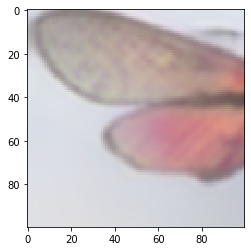

In [22]:
plt.imshow(w_img)

In [23]:
from sklearn.cluster import OPTICS, DBSCAN, KMeans, Birch
cls = Birch(n_clusters=None, threshold=16)
#cls = Birch(n_clusters=32)#, threshold=16)
#cls = OPTICS(min_samples=220, max_eps=16)
color_groups = cls.fit_predict(np.concatenate(rgbs).astype(float))
# cls.fit(np.concatenate(rgbs).astype(np.float32))

In [24]:
idx_counter = 0
wing_color_groups = []
distinct_colors = []
for color in rgbs:
    wing_color_group = color_groups[idx_counter:idx_counter+color.shape[0]]
    wing_color_groups.append(wing_color_group)
    distinct_colors.append(np.unique(wing_color_group).shape[0])
    idx_counter += color.shape[0]

In [25]:
color_evenness = []
for wing_i, wing_color_group_ in enumerate(wing_color_groups):
    distinct_wing_colors_, color_counts_ = np.unique(wing_color_group_, return_counts=True)
    H = -np.sum([(p/len(wing_color_group_)) * np.log(p/len(wing_color_group_)) for p in color_counts_])
    J = H / np.log(len(color_counts_))
    color_evenness.append(J)

#########################################################

In [26]:
#######################################################
target_measurements = dict(
    color_saturation = hsv_mean[:, 1],
    color_brightness = gray_mean,
    color_richness = distinct_colors,
    color_evenness = color_evenness,
    rgb_red = rgb_means[:, 0],
    rgb_green = rgb_means[:, 1],
    rgb_blue = rgb_means[:, 2],
)

famv = []
for w_ in target_img_files:
    famv.append(w_.split('/')[-1].split('_')[0])

wing_characters[target] = pd.DataFrame(dict(family = famv))

for key in target_measurements.keys():
    target_var = target_measurements[key]
    wing_characters[target][key] = target_var

In [27]:
wing_characters['orig']

,family,color_saturation,color_brightness,color_richness,color_evenness,rgb_red,rgb_green,rgb_blue
0,Adelidae,73.7118,128.0365,48,0.596106,144.5352,123.2739,109.0396
1,Adelidae,65.6131,153.0321,53,0.789351,164.1384,151.8277,130.2142
2,Adelidae,93.9189,128.3673,44,0.809279,143.4135,127.0262,95.8333
3,Adelidae,89.6243,151.5356,41,0.850246,157.9095,156.3854,109.8722
4,Adelidae,40.1584,154.4740,30,0.725725,158.7526,154.9679,140.5215
...,...,...,...,...,...,...,...,...
1066,Zygaenidae,37.5456,203.7021,54,0.578286,216.0836,199.9233,189.6370
1067,Zygaenidae,25.5401,212.7985,36,0.638479,222.8941,209.0482,205.9685
1068,Zygaenidae,42.7631,178.3467,45,0.662679,190.7408,173.4291,170.9495
1069,Zygaenidae,45.0786,161.3081,43,0.642262,171.2277,157.7642,152.8345


In [28]:
wing_characters['d40']

,family,color_saturation,color_brightness,color_richness,color_evenness,rgb_red,rgb_green,rgb_blue
0,Adelidae,56.0176,138.8339,25,0.606422,153.0779,134.9005,121.7146
1,Adelidae,58.3621,161.8789,51,0.777954,172.0797,161.0298,139.5499
2,Adelidae,84.1478,138.1354,30,0.814089,152.0251,137.2500,106.3536
3,Adelidae,75.0109,154.8231,23,0.870527,163.7223,157.0591,119.9886
4,Adelidae,32.5930,158.0313,19,0.742164,163.9624,157.1380,147.2307
...,...,...,...,...,...,...,...,...
1066,Zygaenidae,33.0686,202.0442,42,0.574567,215.5608,196.8144,193.5633
1067,Zygaenidae,23.6708,207.4372,26,0.623324,214.1335,205.1479,201.8040
1068,Zygaenidae,32.3503,184.0720,31,0.619422,194.6335,179.4947,179.7621
1069,Zygaenidae,41.1873,165.9752,39,0.646599,179.2883,160.3955,159.7481


In [29]:
wing_characters['d512']

,family,color_saturation,color_brightness,color_richness,color_evenness,rgb_red,rgb_green,rgb_blue
0,Adelidae,58.9148,136.1403,42,0.511093,149.4683,132.6199,118.9473
1,Adelidae,58.6045,153.1695,53,0.756117,164.5206,151.3919,132.5483
2,Adelidae,80.5828,129.7757,30,0.779027,143.1620,128.4613,101.4482
3,Adelidae,76.4033,159.8672,28,0.851093,168.2284,162.5272,124.2211
4,Adelidae,39.7315,158.0636,26,0.778232,165.9878,156.6284,144.7544
...,...,...,...,...,...,...,...,...
1066,Zygaenidae,32.5024,204.0438,43,0.610017,216.2853,199.4241,195.6592
1067,Zygaenidae,24.8917,206.0218,26,0.622202,215.0742,202.1411,202.4437
1068,Zygaenidae,36.3152,179.1507,35,0.595817,191.7403,173.0572,177.4078
1069,Zygaenidae,45.0906,168.3490,43,0.662559,181.3814,163.0016,161.6326


In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# wing_characters_tmp0 = pd.DataFrame(scaler.fit_transform(wing_characters['orig'][target_measurements.keys()]), columns=target_measurements.keys())
# wing_characters_tmp1 = pd.DataFrame(scaler.fit_transform(wing_characters['d40'][target_measurements.keys()]), columns=target_measurements.keys())
# wing_characters_tmp2 = pd.DataFrame(scaler.fit_transform(wing_characters['d512'][target_measurements.keys()]), columns=target_measurements.keys())

wing_characters_tmp0 = pd.DataFrame(wing_characters['orig'][target_measurements.keys()], columns=target_measurements.keys())
wing_characters_tmp1 = pd.DataFrame(wing_characters['d40'][target_measurements.keys()], columns=target_measurements.keys())
wing_characters_tmp2 = pd.DataFrame(wing_characters['d512'][target_measurements.keys()], columns=target_measurements.keys())


# wing_characters_tmp0 = pd.DataFrame(wing_characters['orig'][target_measurements.keys()], columns=target_measurements.keys())
# wing_characters_tmp1 = pd.DataFrame(wing_characters['d40'][target_measurements.keys()], columns=target_measurements.keys())


In [31]:
# wing_characters_tmp0.to_csv('./rec_correlation_test/nearest2centroids1000_orig.csv', index=False)
# wing_characters_tmp1.to_csv('./rec_correlation_test/nearest2centroids1000_d40.csv', index=False)
# wing_characters_tmp2.to_csv('./rec_correlation_test/nearest2centroids1000_d512.csv', index=False)

In [2]:
import pandas as pd
wing_characters_tmp0 = pd.read_csv('./rec_correlation_test/nearest2centroids1000_orig.csv')
wing_characters_tmp1 = pd.read_csv('./rec_correlation_test/nearest2centroids1000_d40.csv')
wing_characters_tmp2 = pd.read_csv('./rec_correlation_test/nearest2centroids1000_d512.csv')

In [58]:
# plt.rcParams['figure.figsize'] = [5, 5]
# for k in target_measurements:
#     plt.figure()
#     plt.scatter(wing_characters[0][target_wings][k], wing_characters[1][target_wings][k], s=50, alpha=.8)
#     plt.title(k)

In [6]:
def adjusted_r_squared(r_squared, n, p):
    return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

target_measurement_keys = dict(
    color_saturation = None,
    color_brightness = None,
    color_richness = None,
    color_evenness = None,
    rgb_red = None,
    rgb_green = None,
    rgb_blue = None,
)

import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
var1 = wing_characters_tmp0
var2 = wing_characters_tmp1
for k in target_measurement_keys:
#     plt.figure()
##     plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed')
#     plt.scatter(var1[k], var2[k], s=50, alpha=.3, label='512D')
##     plt.scatter(wing_characters_tmp0[k], wing_characters_tmp2[k], s=50, alpha=.8, label='40D')
##     plt.scatter(wing_characters_tmp1[k], wing_characters_tmp2[k], s=50, alpha=.8)
##     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[k], y[k])
    pearsons_r, p = stats.pearsonr(var1[k], var2[k])
##     r2 = pearsons_r**2
##     adj_r2 = adjusted_r_squared(r2, len(x), 1)
##     print(k, r_value, p_value)
    print(k, pearsons_r, p)
#     plt.legend()
#     plt.title(k)

color_saturation 0.9757831988221644 0.0
color_brightness 0.9853402574514025 0.0
color_richness 0.8655058941779545 3e-323
color_evenness 0.7461021196986399 4.9059940810184875e-191
rgb_red 0.9840788834927958 0.0
rgb_green 0.9851619272428014 0.0
rgb_blue 0.9807173605026271 0.0


In [7]:
var1 = wing_characters_tmp0
var2 = wing_characters_tmp2
for k in target_measurement_keys:
#     plt.figure()
##     plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed')
#     plt.scatter(var1[k], var2[k], s=50, alpha=.3, label='512D')
##     plt.scatter(wing_characters_tmp0[k], wing_characters_tmp2[k], s=50, alpha=.8, label='40D')
##     plt.scatter(wing_characters_tmp1[k], wing_characters_tmp2[k], s=50, alpha=.8)
##     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[k], y[k])
    pearsons_r, p = stats.pearsonr(var1[k], var2[k])
##     r2 = pearsons_r**2
##     adj_r2 = adjusted_r_squared(r2, len(x), 1)
##     print(k, r_value, p_value)
    print(k, pearsons_r, p)
#     plt.legend()
#     plt.title(k)

color_saturation 0.980027628988481 0.0
color_brightness 0.9867538663556592 0.0
color_richness 0.8646527943099457 7e-322
color_evenness 0.761162811851434 3.026261234783841e-203
rgb_red 0.9872191588444633 0.0
rgb_green 0.986334462309979 0.0
rgb_blue 0.9819230648002393 0.0
